# Statistics for regression model

Absolute and relative error for Lab images of glasses and cups model.

In [1]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2021-11-03_Lab_All_CopasVasos_All_reg'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

W1119 09:35:18.208162 139812046260032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1119 09:35:18.210899 139812046260032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1119 09:35:18.212519 139812046260032 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

In [26]:
import pandas as pd
# Load back the predictions
SPLIT_NAME='test'
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)

df_pred=pd.DataFrame(pred_dict)
df_pred['abs_error']=abs(df_pred.pred_value-df_pred.true_value)

In [27]:
# extract values of angle, plane and background in all images
df_pred['plane'] = df_pred.apply(lambda row: row.filenames.split('_')[-2], axis=1)
df_pred['angle'] = df_pred.apply(lambda row: row.filenames.split('_')[-1].split('.')[0], axis=1)
df_pred['back'] = df_pred.apply(lambda row: row.filenames.split('_')[-4], axis=1)
df_pred['vol'] = df_pred.apply(lambda row: row.filenames.split('_')[4], axis=1)
df_pred['glass'] = df_pred.apply(lambda row: row.filenames.split('_')[3], axis=1)
df_pred['ref'] = df_pred.apply(lambda row: row.filenames.split('_')[-3], axis=1)
df_pred['light'] = df_pred.apply(lambda row: row.filenames.split('_')[-5], axis=1)
df_pred.head(5)

,filenames,pred_value,true_value,abs_error,plane,angle,back,vol,glass,ref,light
0,/srv/datos/Laboratorio/La Rioja/ICVV/Copa Char...,74.349709,75,0.650291,ce,cen,az,75,Char,con,nf
1,/srv/datos/Laboratorio/La Rioja/ICVV/Vaso Dura...,95.382797,100,4.617203,me,sup1,bl,100,Dura,sin,nf
2,/srv/datos/Laboratorio/Madrid/copa Char/Fondo ...,194.206573,200,5.793427,ce,inf,bl,200,Char,con,f
3,/srv/datos/Laboratorio/Madrid/copa Char/Fondo ...,195.143982,200,4.856018,me,inf,bl,200,Char,sin,nf
4,/srv/datos/Laboratorio/La Rioja/ICVV/Copa Borg...,98.471153,100,1.528847,me,sup1,bl,100,Bor,con,f


In [30]:
df_pred['vol']=df_pred.vol.astype(int)
df_pred['rel_error']=df_pred.abs_error/df_pred.vol

In [92]:
# group by vol
df_vols=df_pred.groupby(['vol'], as_index=False)['abs_error'].mean()
df_backs=df_pred.groupby(['back'], as_index=False)['abs_error'].mean()
df_planes=df_pred.groupby(['plane'], as_index=False)['abs_error'].mean()
df_angles=df_pred.groupby(['angle'], as_index=False)['abs_error'].mean()
df_glasses=df_pred.groupby(['glass'], as_index=False)['abs_error'].mean()

In [89]:
# rename values 
df_backs['back'].loc[(df_backs['back'] == 'nd')] = 'outside'
df_backs['back'].loc[(df_backs['back'] == 'bl')] = 'white'
df_backs['back'].loc[(df_backs['back'] == 'az')] = 'blue'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


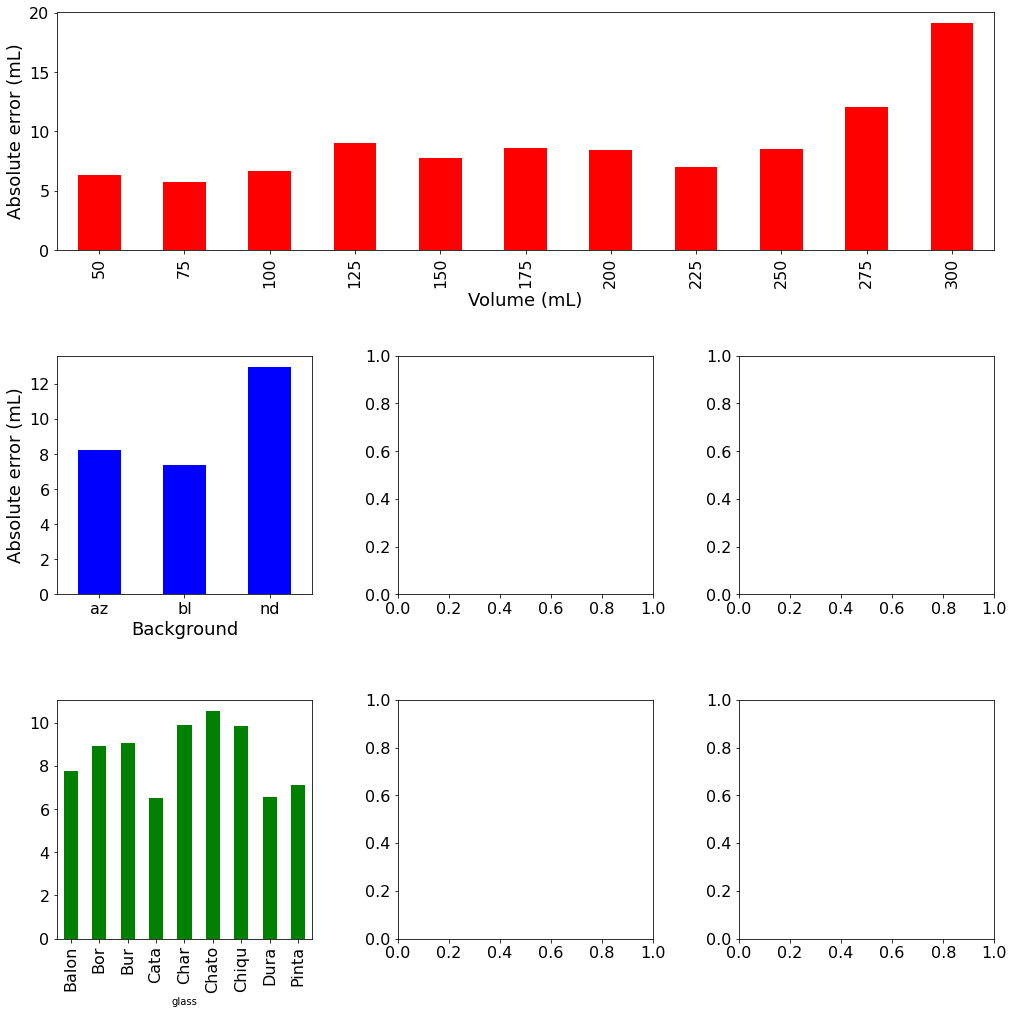

In [99]:
figsize = 5

fig, axs = plt.subplots(3, 3, figsize=(figsize*3, figsize*3))

gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0, 0:]:
    ax.remove()
axbig = fig.add_subplot(gs[0, 0:])

df_vols.plot.bar(x='vol', y='abs_error', ax=axbig, color=['red'], legend=None)
axbig.set_xlabel('Volume (mL)', fontsize=18)
axbig.set_ylabel('Absolute error (mL)', fontsize=18)
axbig.tick_params(axis='x', rotation=90)
axbig.tick_params(axis='both', which='major', labelsize=16)

axs = axs.T.flatten()
axs = axs[1:]

df_backs.plot.bar(x='back', y='abs_error', ax=axs[0], color=['blue'], legend=None)
axs[0].set_xlabel('Background', fontsize=18)
axs[0].set_ylabel('Absolute error (mL)', fontsize=18)
axs[0].tick_params(axis='x', rotation=0)

df_glasses.plot.bar(x='glass', y='abs_error', ax=axs[1], color=['green'], legend=None)
axs[2].set_xlabel('Glass', fontsize=18)
axs[2].set_ylabel('Absolute error (mL)', fontsize=18)
axs[2].tick_params(axis='x', rotation=0)

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=16)
    
fig.tight_layout(pad=4.0)
# plt.savefig('/srv/image-results/abs_error.pdf',bbox_inches='tight')

In [98]:
df_glasses

,glass,abs_error
0,Balon,7.766371
1,Bor,8.948759
2,Bur,9.066302
3,Cata,6.523920
4,Char,9.913932
5,Chato,10.543576
6,Chiqu,9.858446
7,Dura,6.546197
8,Pinta,7.132631


In [ ]:
# mean absolute error for each kind of glass

In [4]:
pred_dict.keys()

dict_keys(['filenames', 'pred_value', 'true_value'])